# Task 3: Model Explainability with SHAP

This notebook explains the predictions of the trained RandomForest fraud detection model using SHAP (SHapley Additive exPlanations).

Objectives:
- Understand global drivers of fraud predictions
- Explain individual predictions (TP, FP, FN)
- Translate model insights into actionable business recommendations

In [1]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

d:\KAIM\fraud-detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load trained model
model = joblib.load("../models/random_forest_fraud_model.joblib")

# Load processed test data (no retraining)
X_test = pd.read_csv("../data/processed/fraud_features.csv")
y_test = pd.read_csv("../data/processed/fraud_target.csv").squeeze()

print("X_test shape:", X_test.shape)


X_test shape: (129146, 199)


## Baseline Feature Importance

We first examine the built-in feature importance from the RandomForest model.
This provides a high-level view of which features influence fraud detection,
but does not explain the direction or per-transaction impact.

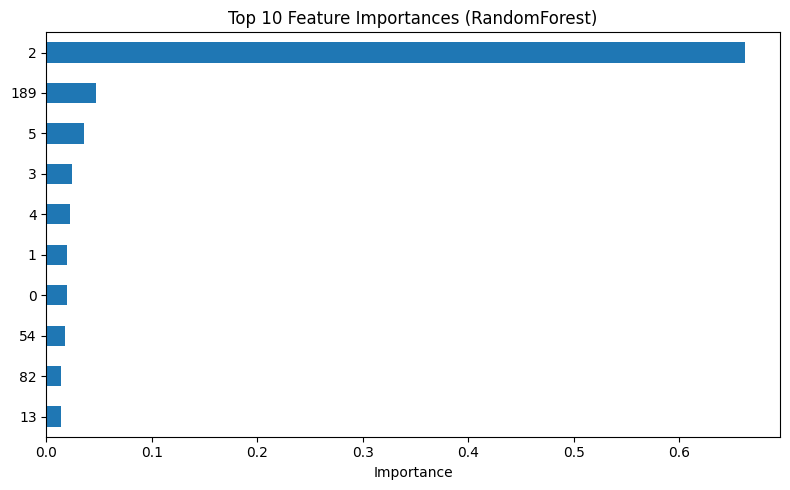

In [3]:
importances = pd.Series(
    model.feature_importances_,
    index=X_test.columns
).sort_values(ascending=False)

top10 = importances.head(10).sort_values()

plt.figure(figsize=(8, 5))
top10.plot(kind="barh")
plt.title("Top 10 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## SHAP Explainability

To obtain both global and local explanations, we use SHAP with a TreeExplainer.
SHAP values show how each feature pushes a prediction toward fraud or non-fraud.

In [9]:
# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for fraud class (class = 1)
# Note: some SHAP versions return an ndarray shaped (n_samples, n_features, n_classes)
# so we take the class axis at index 1 to get (n_samples, n_features)
shap_values = explainer.shap_values(X_test)[:, :, 1]

print("SHAP values shape:", shap_values.shape)

SHAP values shape: (129146, 199)


In [7]:
# Diagnostic: inspect raw explainer output
vals = explainer.shap_values(X_test)
print("type(vals):", type(vals))
try:
    print("len(vals):", len(vals))
except Exception as e:
    print("len error:", e)
if isinstance(vals, (list, tuple)):
    for i, v in enumerate(vals):
        print(f"vals[{i}] -> type: {type(v)}, shape: {getattr(v, 'shape', None)}, ndim: {getattr(v,'ndim', None)}")
else:
    print("vals -> shape:", getattr(vals, 'shape', None), "ndim:", getattr(vals, 'ndim', None))

print("shap_values (current) shape:", getattr(shap_values, 'shape', None))
print("X_test shape:", X_test.shape)

type(vals): <class 'numpy.ndarray'>
len(vals): 129146
vals -> shape: (129146, 199, 2) ndim: 3
shap_values (current) shape: (199, 2)
X_test shape: (129146, 199)


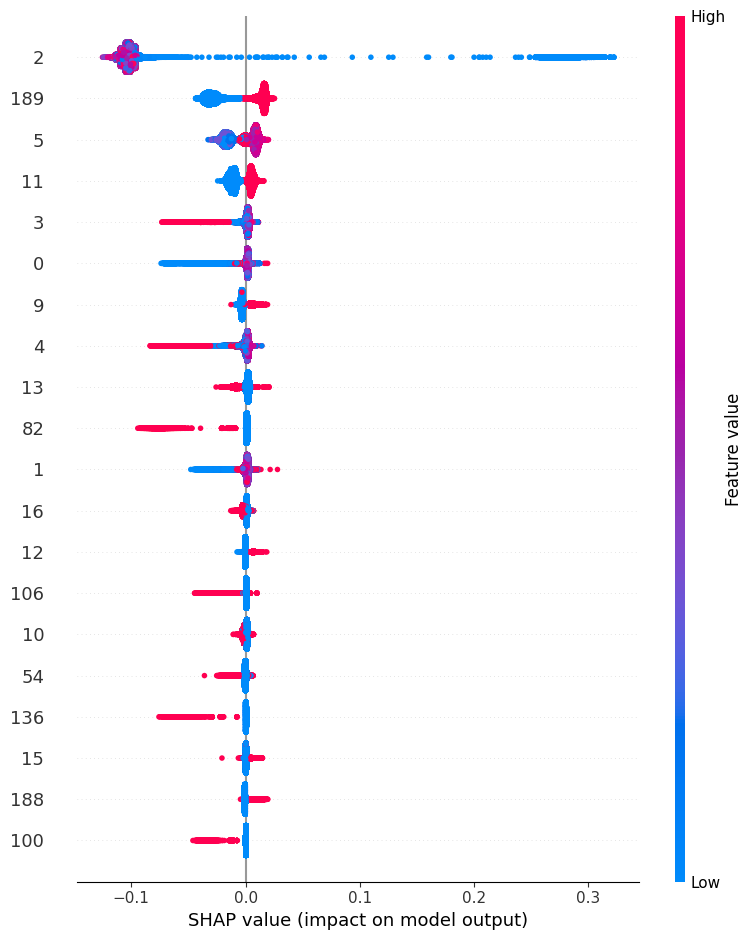

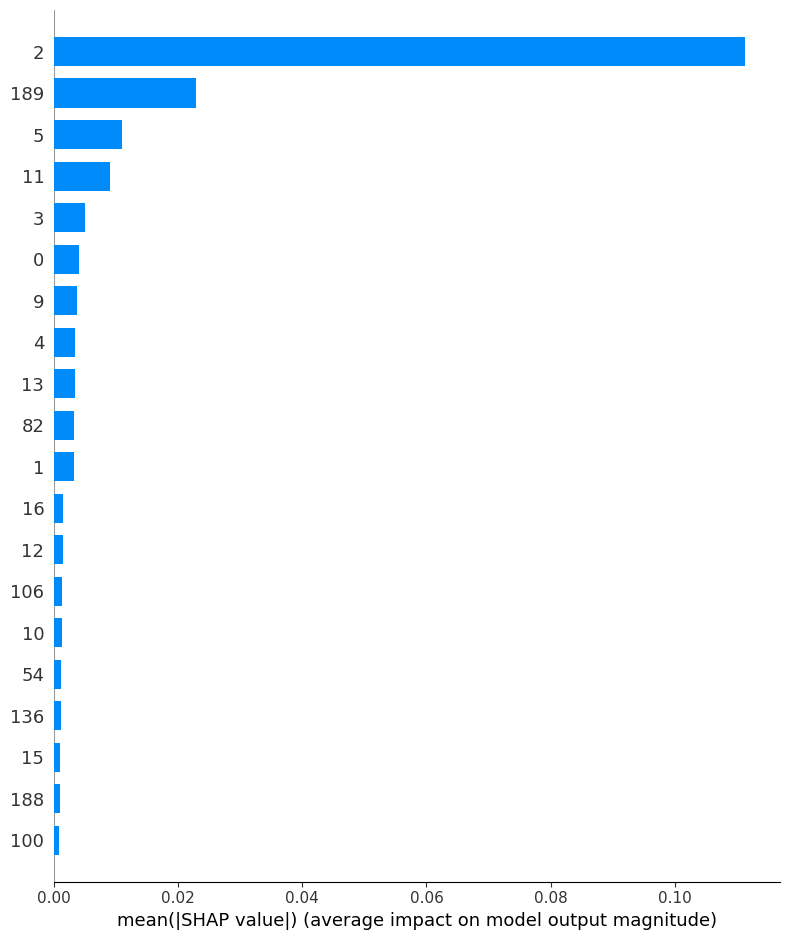

In [11]:
# Global SHAP summary plot
shap.summary_plot(shap_values, X_test)

# Mean absolute SHAP importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

## Global SHAP Interpretation

The SHAP summary plots reveal the most influential features driving fraud predictions.
Red values indicate higher feature values, while blue values indicate lower values.

Features at the top consistently contribute the most to identifying fraudulent transactions,
confirming that the model relies on meaningful behavioral and transactional signals.

In [13]:
# Model predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Identify example indices
tp_idx = np.where((y_test == 1) & (y_pred == 1))[0][0]
fp_idx = np.where((y_test == 0) & (y_pred == 1))[0][0]
fn_idx = np.where((y_test == 1) & (y_pred == 0))[0][0]

tp_idx, fp_idx, fn_idx

(np.int64(48), np.int64(5555), np.int64(45))

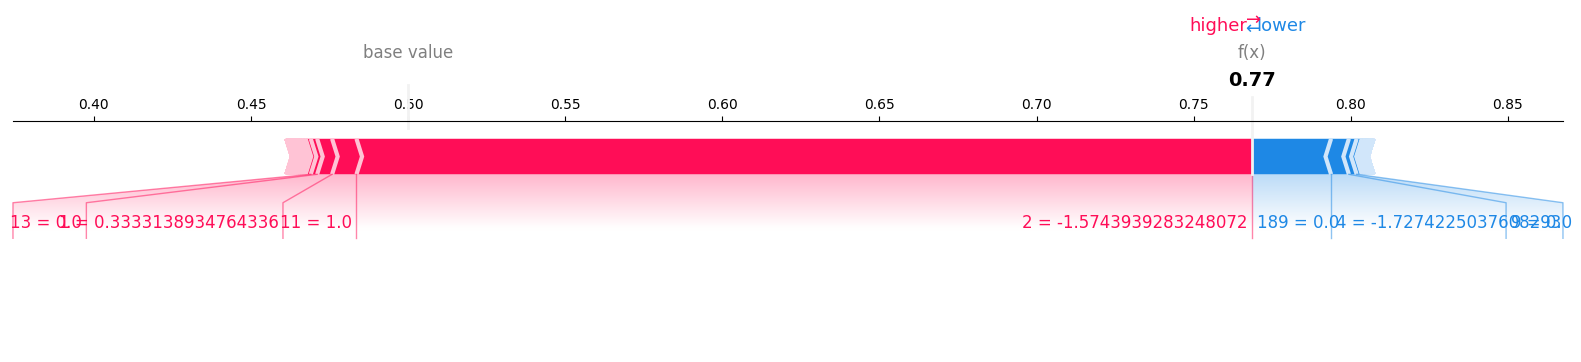

In [14]:
# Code (True Positive Explanation)
shap.force_plot(
    explainer.expected_value[1],
    shap_values[tp_idx],
    X_test.iloc[tp_idx],
    matplotlib=True
)


### True Positive (Correct Fraud Detection)

The model correctly identified this transaction as fraudulent.
Several features strongly pushed the prediction toward fraud,
demonstrating effective detection of high-risk behavior.

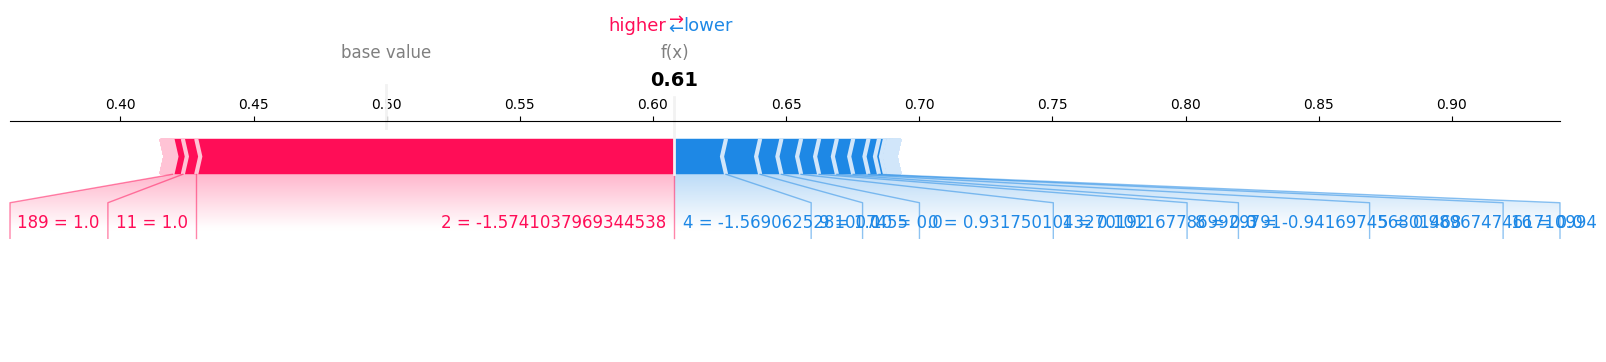

In [15]:
shap.force_plot(
    explainer.expected_value[1],
    shap_values[fp_idx],
    X_test.iloc[fp_idx],
    matplotlib=True
)

### False Positive (Legitimate Transaction Flagged)

This transaction was incorrectly flagged as fraud.
Some features resembled fraudulent patterns, suggesting the need for
additional verification steps rather than automatic rejection.


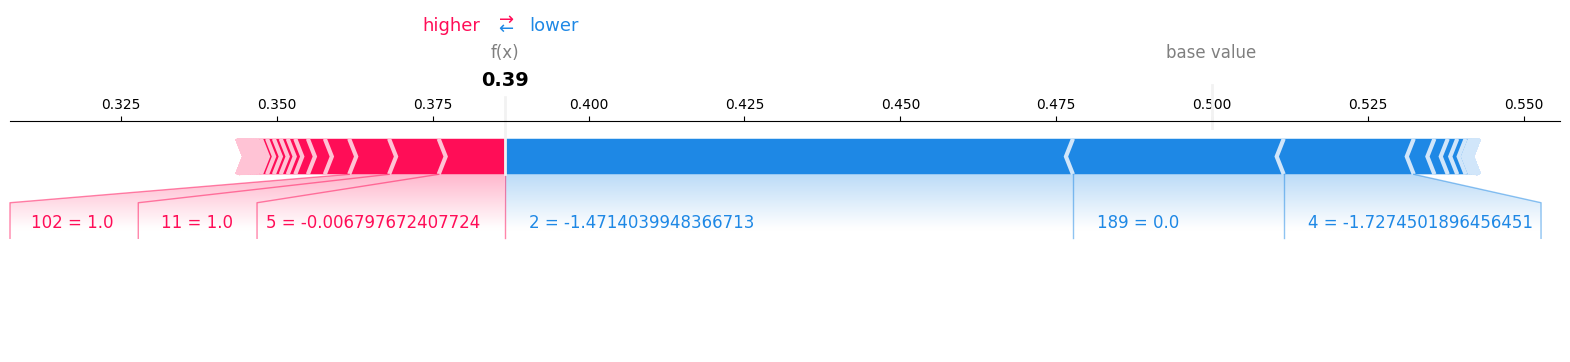

In [16]:
# Code (False Negative Explanation)
shap.force_plot(
    explainer.expected_value[1],
    shap_values[fn_idx],
    X_test.iloc[fn_idx],
    matplotlib=True
)


### False Negative (Missed Fraud)

The model failed to detect this fraudulent transaction due to weak or ambiguous signals.
This highlights areas where additional features or external data could improve detection.

# Business Recommendations

* **Prioritize Top SHAP Features**
  Map the highest mean(|SHAP|) features identified in `shap-explainability.ipynb` to concrete verification rules and exception handling. Use these signals to route high-risk transactions into a staged review workflow.

* **Soft Interventions**
  For borderline SHAP scores, apply lightweight friction (e.g., OTP, email or in-app confirmation) instead of outright declines. This reduces false positives while preserving customer experience.

* **Secondary Verification Queue**
  Route transactions triggered by features known to generate false positives into a fast secondary check (automated or manual), such as device fingerprint validation or recent behavioral analysis, before taking final action.

* **Enrich to Reduce False Negatives**
  Introduce targeted data enrichment (device reputation, recent chargeback history, IP geolocation consistency) and retrain the model with emphasis on cases where SHAP indicates weak or diffuse signals.

* **Human-in-the-Loop Logging**
  Persist analyst decisions together with the SHAP explanations reviewed. Use this feedback loop to recalibrate thresholds and periodically retrain the model with higher-quality labels.

* **SHAP Drift Monitoring**
  Monitor weekly trends in mean(|SHAP|) per feature and changes in top-feature rankings. Trigger alerts when significant shifts occur to initiate model and data quality reviews.

* **Explainability in Operations**
  Surface concise, SHAP-driven explanations in fraud analyst dashboards and customer-service tools to accelerate triage, support audits, and improve transparency.

* **Policy and Threshold Management**
  Implement safety guardrails by combining model probability and SHAP magnitude. For example, enforce auto-declines only when both exceed strict thresholds; otherwise, escalate to review or apply soft checks.


## Conclusion

SHAP explainability confirms that the RandomForest model bases its decisions on meaningful transaction patterns.
These insights improve transparency, trust, and support data-driven fraud prevention strategies.